# eXtreme Gradient Boosting(XGBoost)

XGBoost, GBM'in hız ve tahmin performasını arttırmak üzere optimize edilmiş; ölçeklenebilir ve farklı platformlara entegre edilebilir halidir. (2014, Tianqi Chen)

- R, Python, Hadoop, Scala, Julia ile kullanılabilir.

- Ölçeklenebilirdir.

- Hızlıdır.

- Tahmin başarısı yüksektir.

- Bir çok kaggle yarışmasında başarısını kanıtlamıştır.

------

# 1. Model (XGB)

In [1]:
!pip install xgboost

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from xgboost import XGBRegressor

from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
hit = pd.read_csv("Hitters.csv")

df = hit.copy()

df = df.dropna()

df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [4]:
dms = pd.get_dummies(df[["League", "Division", "NewLeague"]])

dms.head()

,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,0,1,0,1,0,1
2,1,0,0,1,1,0
3,0,1,1,0,0,1
4,0,1,1,0,0,1
5,1,0,0,1,1,0


In [5]:
X_ = df.drop(["Salary", "League", "Division", "NewLeague"], axis = 1).astype("float64")

X_.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors
1,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0
2,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0
3,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0
4,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0
5,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0


In [6]:
X = pd.concat([X_, dms[["League_N", "Division_W", "NewLeague_N"]]], axis = 1)

X.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
1,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,1,1,1
2,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,0,1,0
3,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,1,0,1
4,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,1,0,1
5,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0,0,1,0


In [7]:
y = df["Salary"]

y.head()

1    475.0
2    480.0
3    500.0
4     91.5
5    750.0
Name: Salary, dtype: float64

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [9]:
DM_train = xgb.DMatrix(data = X_train, label = y_train)

DM_test = xgb.DMatrix(data = X_test, label = y_test) 

In [20]:
xgb_model = XGBRegressor().fit(X_train, y_train)

[18:07:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


----------------

# 2. Tahmin (XGB)

In [21]:
xgb_model.predict(X_test)

array([ 780.3947  ,  697.20703 , 1384.2264  ,  193.56989 ,  706.8243  ,
        353.68878 ,  247.5688  ,  121.11607 ,  650.2349  ,  611.39594 ,
        719.03143 ,  783.25226 ,  584.19507 ,  176.40022 ,  314.3358  ,
       1160.9492  ,  860.3143  ,   91.81009 ,  699.6243  ,  281.95734 ,
        363.03082 ,  817.3743  ,  700.335   ,  608.46906 ,  406.63147 ,
        105.938095,  814.5855  ,  376.6216  ,  631.84064 ,  158.63531 ,
        115.2102  ,  714.7235  ,  511.93768 ,  204.96744 ,  243.9267  ,
       1086.2357  , 1704.9283  ,  219.19572 ,  167.94234 ,  475.77008 ,
         85.39883 ,  141.77531 ,  567.23834 ,  708.3083  , 1539.7263  ,
        718.7946  ,  500.31982 ,   81.4075  ,  233.04205 ,  668.5475  ,
        764.2695  ,  450.55878 ,  727.136   ,  168.51653 ,  108.558235,
        815.25323 ,  608.8967  ,  727.00903 ,  258.15967 , 1681.5763  ,
        892.86176 ,  544.8748  ,  670.23083 ,  425.2355  ,  648.9491  ,
         86.36467 ], dtype=float32)

In [22]:
y_pred = xgb_model.predict(X_test)

np.sqrt(mean_squared_error(y_test, y_pred))

359.91750599447033

------

# 3. Model Doğrulama / Moden Tuning (XGB)

In [23]:
xgb_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [24]:
xgb_grid = {"colsample_bytree" : [0.4, 0.5, 0.6, 0.9, 1],
           "n_estimators" : [100, 200, 500, 1000],
           "max_depth" : [2, 3, 4, 5, 6],
           "learning_rate" : [0.1, 0.01, 0.5, 0.05]}

In [25]:
xgb_model = XGBRegressor()

xgb_cv_model = GridSearchCV(xgb_model, param_grid = xgb_grid, cv = 10, n_jobs = -1, verbose = 2)

xgb_cv_model.fit(X_train, y_train)

Fitting 10 folds for each of 400 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:  6.6min finished


[18:20:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'colsample_bytree': [0.4, 0.5, 0.6, 0.9, 1],
                         'learning_rate': [0.1, 0.01,

In [26]:
xgb_cv_model.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 500}

In [27]:
xgb_tuned = XGBRegressor(colsample_bytree = 0.5, learning_rate = 0.1, max_depth = 2, n_estimators = 500)

xgb_tuned.fit(X_train, y_train)

y_pred = xgb_tuned.predict(X_test)

np.sqrt(mean_squared_error(y_test, y_pred))

[18:26:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


346.0275157777717

In [28]:
xgb_tuned.feature_importances_

array([0.0463685 , 0.05017385, 0.01944326, 0.05054241, 0.01843253,
       0.0394595 , 0.04224918, 0.08118097, 0.22247925, 0.06736211,
       0.11385711, 0.13855474, 0.03101878, 0.03812085, 0.00308825,
       0.01530034, 0.01173346, 0.00110582, 0.00952907], dtype=float32)

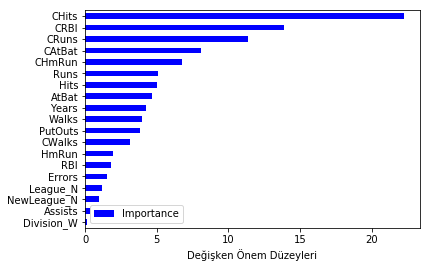

In [32]:
Importance = pd.DataFrame({"Importance" : xgb_tuned.feature_importances_ * 100}, index = X_train.columns)

Importance.sort_values(by = "Importance", axis = 0, ascending = True).plot(kind = "barh", color = "blue")

plt.xlabel("Değişken Önem Düzeyleri");